In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import imageio
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

print("tf version: {}".format(tf.__version__))
%matplotlib inline

tf version: 2.10.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
IMG_SIZE = 224
BATCH = 32

train = tf.keras.preprocessing.image_dataset_from_directory(
    'data/train',
    shuffle = True,
    image_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH
)
classes = train.class_names

val = tf.keras.preprocessing.image_dataset_from_directory(
    'data/valid',
    shuffle = True,
    image_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    'data/test',
    shuffle = True,
    image_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH
)

Found 8409 files belonging to 7 classes.
Found 1753 files belonging to 7 classes.
Found 2603 files belonging to 7 classes.


In [4]:
# autotune
train.cache().shuffle(buffer_size= len(train)).prefetch(buffer_size=tf.data.AUTOTUNE)
val.cache().shuffle(buffer_size = len(val)).prefetch(buffer_size=tf.data.AUTOTUNE)
test.cache().shuffle(buffer_size = len(test)).prefetch(buffer_size=tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Буду переводить данные от 0-1, и изменять размер картинки

In [5]:
# ф-я перевода данных 0-1
normalization = tf.keras.layers.experimental.preprocessing.Rescaling(1./255) # [0,1]
# normalization = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5) # [-1, 1]

In [6]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [7]:
IMG_SIZE

224

In [8]:
# train = train.map(lambda x, y: (normalization(x), y))
# test = test.map(lambda x, y: (normalization(x), y))
# val = val.map(lambda x, y: (normalization(x), y))

Аугментация

In [9]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.3),
#   layers.RandomCrop (180, 180),
])

In [10]:
img = imageio.imread(r'data\test\ISIC_0012258.jpg')

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """Entry point for launching an IPython kernel.


In [11]:
img = tf.image.resize(img, (224, 224))

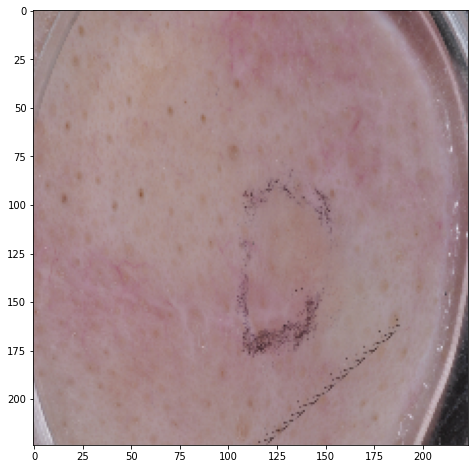

In [12]:
plt.figure(figsize=(8, 8))
plt.imshow(img/255.)

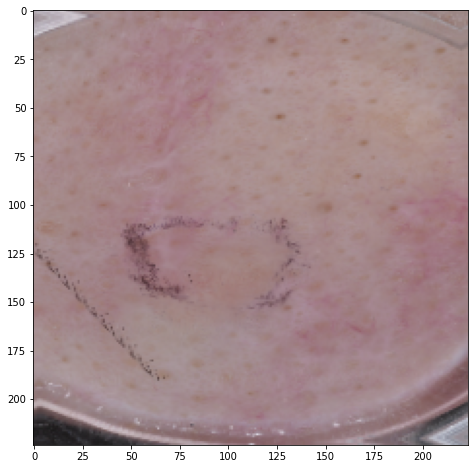

In [13]:
img1 = tf.constant(img/255.)
img1 = data_augmentation(img1)
plt.figure(figsize=(8, 8))
plt.imshow(img1)

# Создание модели

### vgg16

In [14]:
from tensorflow.keras.applications.vgg16 import VGG16


In [15]:
base_model = VGG16(input_shape = (224, 224, 3), 
include_top = False, 
weights = None
    )
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
classes

['carcinoma',
 'dermatofibroma',
 'keratosis',
 'melanoma',
 'nevus',
 'seborrheic_keratosis',
 'vascular_lesions']

In [17]:
for layer in base_model.layers:
    layer.trainable = True

In [18]:

model = models.Sequential([
    resize_rescale,
#     data_augmentation,
    base_model,
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(4096,activation = 'relu'),
    layers.Dense(4096,activation = 'relu'),
    layers.Dense(1000,activation = 'relu'),
    layers.Dense(len(classes),activation = 'softmax')
])

model.build(input_shape=(None,IMG_SIZE,IMG_SIZE,3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 512)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 4096)              18878464  
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                      

In [19]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [20]:
from keras.callbacks import EarlyStopping
# early_stop = EarlyStopping(monitor= 'loss', patience=5,mode = 'min' ,verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,mode = 'min' ,verbose=1)

In [21]:
%%time
# train standart
EPOCHS = 15
history = model.fit(
        train,
        shuffle = True,
        epochs = EPOCHS,
        batch_size = BATCH,
        verbose = 2,
        validation_data = val,
        callbacks = [early_stop]
    )

In [ ]:
if os.path.isdir("history") == False:
    os.mkdir("history")
with open(f'history/hist_vgg', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [22]:
# df_vgg = pd.DataFrame(columns=["model","loss","accuracy","val_loss","val_accuracy"])

In [25]:
# %%time
# # test
# EPOCHS = 100
# for i in tqdm(range(EPOCHS)):
#     dict_ = {}
#     history = model.fit(
#         train,
#         shuffle = True,
#         epochs = 1,
#         batch_size = BATCH,
#         verbose = 2,
#         validation_data = val,
# #         callbacks = [early_stop]
#     )
#     name_model = 'model' + f"_epochs_{i}"
#     dict_['model'] = name_model
#     dict_['loss'] = round(history.history['loss'][0],4)
#     dict_['accuracy'] = round(history.history['accuracy'][0],4)
#     dict_['val_loss'] = round(history.history['val_loss'][0],4)
#     dict_['val_accuracy'] = round(history.history['val_accuracy'][0],4)
    
#     df_vgg = df_vgg.append(dict_,ignore_index=True)
#     df_vgg.to_csv("df_base.csv")
#     if i % 10 == 0:
#         if os.path.isdir("models"):
#             model.save(f"models/{name_model}")
#         else:
#             os.mkdir("models")
#             model.save(f"models/{name_model}")
#     print(df_vgg.tail(1))
#     time.sleep(300)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

263/263 - 3227s - loss: 1.1525 - accuracy: 0.6636 - val_loss: 1.1788 - val_accuracy: 0.6486 - 3227s/epoch - 12s/step


INFO:tensorflow:Assets written to: models/model_epochs_0\assets


INFO:tensorflow:Assets written to: models/model_epochs_0\assets


            model    loss  accuracy  val_loss  val_accuracy
0  model_epochs_0  1.1525    0.6636    1.1788        0.6486


  1%|▊                                                                            | 1/100 [58:52<97:07:55, 3532.08s/it]

263/263 - 3197s - loss: 1.1220 - accuracy: 0.6755 - val_loss: 1.1555 - val_accuracy: 0.6486 - 3197s/epoch - 12s/step
            model   loss  accuracy  val_loss  val_accuracy
1  model_epochs_1  1.122    0.6755    1.1555        0.6486


  2%|█▌                                                                         | 2/100 [1:57:09<95:35:18, 3511.42s/it]

263/263 - 3179s - loss: 1.1192 - accuracy: 0.6755 - val_loss: 1.1582 - val_accuracy: 0.6486 - 3179s/epoch - 12s/step
            model    loss  accuracy  val_loss  val_accuracy
2  model_epochs_2  1.1192    0.6755    1.1582        0.6486


  3%|██▎                                                                        | 3/100 [2:55:07<94:12:33, 3496.43s/it]

263/263 - 3118s - loss: 1.1168 - accuracy: 0.6755 - val_loss: 1.1696 - val_accuracy: 0.6486 - 3118s/epoch - 12s/step
            model    loss  accuracy  val_loss  val_accuracy
3  model_epochs_3  1.1168    0.6755    1.1696        0.6486


  4%|███                                                                        | 4/100 [3:52:05<92:24:54, 3465.57s/it]

263/263 - 3124s - loss: 1.1167 - accuracy: 0.6755 - val_loss: 1.1613 - val_accuracy: 0.6486 - 3124s/epoch - 12s/step
            model    loss  accuracy  val_loss  val_accuracy
4  model_epochs_4  1.1167    0.6755    1.1613        0.6486


  5%|███▊                                                                       | 5/100 [4:49:10<91:03:31, 3450.65s/it]

263/263 - 3116s - loss: 1.1154 - accuracy: 0.6755 - val_loss: 1.1632 - val_accuracy: 0.6486 - 3116s/epoch - 12s/step
            model    loss  accuracy  val_loss  val_accuracy
5  model_epochs_5  1.1154    0.6755    1.1632        0.6486


  6%|████▌                                                                      | 6/100 [5:46:05<89:47:20, 3438.73s/it]

263/263 - 3132s - loss: 1.1159 - accuracy: 0.6755 - val_loss: 1.1577 - val_accuracy: 0.6486 - 3132s/epoch - 12s/step
            model    loss  accuracy  val_loss  val_accuracy
6  model_epochs_6  1.1159    0.6755    1.1577        0.6486


  6%|████▍                                                                     | 6/100 [6:43:18<105:18:24, 4033.02s/it]


KeyboardInterrupt: 

In [26]:
score = model.evaluate(test)

82/82 [==============================] - 187s 2s/step - loss: 1.1300 - accuracy: 0.6650


In [27]:
model.save('model_vgg16')

In [28]:
# df_vgg.tail(10)

,model,loss,accuracy,val_loss,val_accuracy
0,model_epochs_0,1.1525,0.6636,1.1788,0.6486
1,model_epochs_1,1.1220,0.6755,1.1555,0.6486
2,model_epochs_2,1.1192,0.6755,1.1582,0.6486
3,model_epochs_3,1.1168,0.6755,1.1696,0.6486
4,model_epochs_4,1.1167,0.6755,1.1613,0.6486
5,model_epochs_5,1.1154,0.6755,1.1632,0.6486
6,model_epochs_6,1.1159,0.6755,1.1577,0.6486


### Xception

In [14]:
from tensorflow.keras.applications.xception import Xception

In [15]:
base_model_xception = Xception(input_shape = (224, 224, 3), 
include_top = False, 
weights = None
    )
base_model_xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

In [16]:
for layer in base_model_xception.layers:
    layer.trainable = True

In [17]:
model_xception = models.Sequential([
    resize_rescale,
#     data_augmentation,
    base_model_xception,
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(4096,activation = 'relu'),
    layers.Dense(4096,activation = 'relu'),
    layers.Dense(1000,activation = 'relu'),
    layers.Dense(len(classes),activation = 'softmax')
])

model_xception.build(input_shape=(None,IMG_SIZE,IMG_SIZE,3))
model_xception.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (224, 224, 3)             0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 2048)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 4096)              75501568  
                                                      

In [18]:
model_xception.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
%%time
EPOCHS = 15
history = model_xception.fit(
    train,
    shuffle = True,
    epochs = EPOCHS,
    batch_size = BATCH,
    verbose = 2,
    validation_data = val,
    callbacks = [early_stop]
)

In [ ]:
if os.path.isdir("history") == False:
    os.mkdir("history")
with open(f'history/hist_xception', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
# %%time
# # test
# EPOCHS = 100
# for i in tqdm(range(EPOCHS)):
#     dict_ = {}
#     history = model_xception.fit(
#         train,
#         shuffle = True,
#         epochs = 1,
#         batch_size = BATCH,
#         verbose = 2,
#         validation_data = val,
# #         callbacks = [early_stop]
#     )
#     name_model = 'model_xception' + f"_epochs_{i}"
#     dict_['model'] = name_model
#     dict_['loss'] = round(history.history['loss'][0],4)
#     dict_['accuracy'] = round(history.history['accuracy'][0],4)
#     dict_['val_loss'] = round(history.history['val_loss'][0],4)
#     dict_['val_accuracy'] = round(history.history['val_accuracy'][0],4)
    
#     df_vgg = df_base.append(dict_,ignore_index=True)
#     df_vgg.to_csv("df_base.csv")
#     if i % 10 == 0:
#         if os.path.isdir("models"):
#             model.save(f"models/{name_model}")
#         else:
#             os.mkdir("models")
#             model.save(f"models/{name_model}")
# #     time.sleep(300)

In [ ]:
# %%time
# EPOCHS = 100
# for i in tqdm(range(EPOCHS)):
#     history = model_xception.fit(
#     train,
#     shuffle = True,
#     epochs = 1,
#     batch_size = BATCH,
#     verbose = 2,
#     validation_data = val,
# #     callbacks = [early_stop]
#     )
#     score = model_xception.evaluate(test)
#     model_xception.save('model_xception' + f"epoch_{i}")

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

63/63 - 654s - loss: 3.3189 - accuracy: 0.6550 - val_loss: 1.0736 - val_accuracy: 0.5200 - 654s/epoch - 10s/step
19/19 [==============================] - 39s 2s/step - loss: 1.0551 - accuracy: 0.6550


INFO:tensorflow:Assets written to: model_xceptionepoch_0\assets


INFO:tensorflow:Assets written to: model_xceptionepoch_0\assets
  1%|▊                                                                             | 1/100 [11:53<19:36:35, 713.08s/it]

63/63 - 561s - loss: 0.8473 - accuracy: 0.6855 - val_loss: 1.0585 - val_accuracy: 0.5200 - 561s/epoch - 9s/step
19/19 [==============================] - 38s 2s/step - loss: 1.0219 - accuracy: 0.6550


INFO:tensorflow:Assets written to: model_xceptionepoch_1\assets


INFO:tensorflow:Assets written to: model_xceptionepoch_1\assets
  2%|█▌                                                                            | 2/100 [22:17<17:59:42, 661.05s/it]

63/63 - 541s - loss: 0.8354 - accuracy: 0.6860 - val_loss: 1.0451 - val_accuracy: 0.5200 - 541s/epoch - 9s/step
19/19 [==============================] - 39s 2s/step - loss: 0.9839 - accuracy: 0.6550


INFO:tensorflow:Assets written to: model_xceptionepoch_2\assets


INFO:tensorflow:Assets written to: model_xceptionepoch_2\assets
  3%|██▎                                                                           | 3/100 [32:22<17:07:19, 635.46s/it]

63/63 - 552s - loss: 0.8606 - accuracy: 0.6830 - val_loss: 1.0363 - val_accuracy: 0.5200 - 552s/epoch - 9s/step
19/19 [==============================] - 39s 2s/step - loss: 0.9651 - accuracy: 0.6550


INFO:tensorflow:Assets written to: model_xceptionepoch_3\assets


INFO:tensorflow:Assets written to: model_xceptionepoch_3\assets
  4%|███                                                                           | 4/100 [42:38<16:44:04, 627.55s/it]

63/63 - 623s - loss: 0.8044 - accuracy: 0.6860 - val_loss: 1.0361 - val_accuracy: 0.5200 - 623s/epoch - 10s/step
19/19 [==============================] - 40s 2s/step - loss: 0.9741 - accuracy: 0.6550


INFO:tensorflow:Assets written to: model_xceptionepoch_4\assets


INFO:tensorflow:Assets written to: model_xceptionepoch_4\assets
  5%|███▉                                                                          | 5/100 [54:06<17:08:31, 649.60s/it]

63/63 - 616s - loss: 0.7826 - accuracy: 0.6860 - val_loss: 1.0228 - val_accuracy: 0.5200 - 616s/epoch - 10s/step
19/19 [==============================] - 42s 2s/step - loss: 0.9352 - accuracy: 0.6550


INFO:tensorflow:Assets written to: model_xceptionepoch_5\assets


INFO:tensorflow:Assets written to: model_xceptionepoch_5\assets
  6%|████▌                                                                       | 6/100 [1:05:30<17:15:39, 661.06s/it]

63/63 - 614s - loss: 0.7954 - accuracy: 0.6860 - val_loss: 1.0196 - val_accuracy: 0.5200 - 614s/epoch - 10s/step
19/19 [==============================] - 42s 2s/step - loss: 0.9448 - accuracy: 0.6550


INFO:tensorflow:Assets written to: model_xceptionepoch_6\assets


INFO:tensorflow:Assets written to: model_xceptionepoch_6\assets
  7%|█████▎                                                                      | 7/100 [1:16:51<17:15:02, 667.77s/it]

63/63 - 605s - loss: 0.7901 - accuracy: 0.6860 - val_loss: 1.0069 - val_accuracy: 0.5200 - 605s/epoch - 10s/step
19/19 [==============================] - 42s 2s/step - loss: 0.9366 - accuracy: 0.6550


INFO:tensorflow:Assets written to: model_xceptionepoch_7\assets


INFO:tensorflow:Assets written to: model_xceptionepoch_7\assets
  8%|██████                                                                      | 8/100 [1:28:03<17:05:57, 669.10s/it]

63/63 - 614s - loss: 0.7792 - accuracy: 0.6840 - val_loss: 0.9788 - val_accuracy: 0.5200 - 614s/epoch - 10s/step
19/19 [==============================] - 43s 2s/step - loss: 0.9198 - accuracy: 0.6550


INFO:tensorflow:Assets written to: model_xceptionepoch_8\assets


INFO:tensorflow:Assets written to: model_xceptionepoch_8\assets
  9%|██████▊                                                                     | 9/100 [1:39:25<17:01:02, 673.21s/it]

63/63 - 629s - loss: 0.7742 - accuracy: 0.6835 - val_loss: 1.0076 - val_accuracy: 0.5200 - 629s/epoch - 10s/step
19/19 [==============================] - 43s 2s/step - loss: 0.9171 - accuracy: 0.6550


INFO:tensorflow:Assets written to: model_xceptionepoch_9\assets


INFO:tensorflow:Assets written to: model_xceptionepoch_9\assets
 10%|███████▌                                                                   | 10/100 [1:51:02<17:00:49, 680.55s/it]

In [ ]:
score = model_xception.evaluate(test)

In [ ]:
model_xception.save('model_xception')

### ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
base_model_resnet50 = ResNet50(input_shape = (224, 224, 3), 
include_top = False, 
weights = None
    )
base_model_resnet50.summary()

In [ ]:
for layer in base_model_resnet50.layers:
    layer.trainable = True

In [ ]:
model_resnet50 = models.Sequential([
    resize_rescale,
#     data_augmentation,
    base_model_resnet50,
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(4096,activation = 'relu'),
    layers.Dense(4096,activation = 'relu'),
    layers.Dense(1000,activation = 'relu'),
    layers.Dense(len(classes),activation = 'softmax')
])

model_resnet50.build(input_shape=(None,IMG_SIZE,IMG_SIZE,3))
model_resnet50.summary()

In [ ]:
model_resnet50.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
# %%time
# # test
# EPOCHS = 100
# for i in tqdm(range(EPOCHS)):
#     dict_ = {}
#     history = model_resnet50.fit(
#         train,
#         shuffle = True,
#         epochs = 1,
#         batch_size = BATCH,
#         verbose = 2,
#         validation_data = val,
# #         callbacks = [early_stop]
#     )
#     name_model = 'model_resnet50' + f"_epochs_{i}"
#     dict_['model'] = name_model
#     dict_['loss'] = round(history.history['loss'][0],4)
#     dict_['accuracy'] = round(history.history['accuracy'][0],4)
#     dict_['val_loss'] = round(history.history['val_loss'][0],4)
#     dict_['val_accuracy'] = round(history.history['val_accuracy'][0],4)
    
#     df_vgg = df_base.append(dict_,ignore_index=True)
#     df_vgg.to_csv("df_base.csv")
#     if i % 10 == 0:
#         if os.path.isdir("models"):
#             model.save(f"models/{name_model}")
#         else:
#             os.mkdir("models")
#             model.save(f"models/{name_model}")
# #     time.sleep(300)

In [ ]:
%%time
EPOCHS = 100
history = model_resnet50.fit(
    train,
    shuffle = True,
    epochs = EPOCHS,
    batch_size = BATCH,
    verbose = 2,
    validation_data = val,
    callbacks = [early_stop]
)

In [ ]:
if os.path.isdir("history") == False:
    os.mkdir("history")
with open(f'history/hist_resnet50', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
score = model_resnet50.evaluate(test)

In [ ]:
model_resnet50.save('model_resnet50')